# NLP Architect - Named Entity Recognition tutorial

Let's start by importing all the important classes

In [ ]:
import numpy as np
from keras.utils import to_categorical
from nlp_architect.data.sequential_tagging import SequentialTaggingDataset
from nlp_architect.models.ner_crf import NERCRF
from nlp_architect.utils.embedding import load_word_embeddings
from nlp_architect.utils.metrics import get_conll_scores

## Preparing the data

Load a dataset using the `NamedEntityDataset` dataset loader.
The files should be tagged in `BIO` format and each token should appear in a separate line with its tags separated by tabs. For example: `A B-ENTITY`.  Sentence should be separated by an empty line.

Change the train/test paths below to your 

In [ ]:
train = 'train.txt'
test = 'test.txt'

sentence_length = 50
word_length = 12

dataset = SequentialTaggingDataset(train, test,
                             max_sentence_length=sentence_length,
                             max_word_length=word_length,
                             tag_field_no=4)

Get the train and test sets - we have 2 inputs and 1 output (word and chars, and entity type for outout).

In [ ]:
x_train, x_char_train, y_train = dataset.train
x_test, x_char_test, y_test = dataset.test

Convert output matrices into 1-hot encoding

In [ ]:
num_y_labels = len(dataset.y_labels) + 1
y_test = to_categorical(y_test, num_y_labels)
y_train = to_categorical(y_train, num_y_labels)

### External word embedding model

We can use pre-train word embedding models with this network. NLP Architect can load GloVe and Fasttext type of models (text files in <word> <vector weights> format).

For more information and download links visit official pages of [GloVe](https://nlp.stanford.edu/projects/glove/) and [Fasttext](https://fasttext.cc/docs/en/english-vectors.html).

_(The terms and conditions of the data set license apply. Intel does not grant any rights to the data files)_

In the example below we point `embedding_path` to a local GloVe model of size 100.

In [ ]:
embedding_path = 'glove.6B.100d.txt'
embedding_size = 100

## Creating the model
The NER model we're going to build is depicted below:

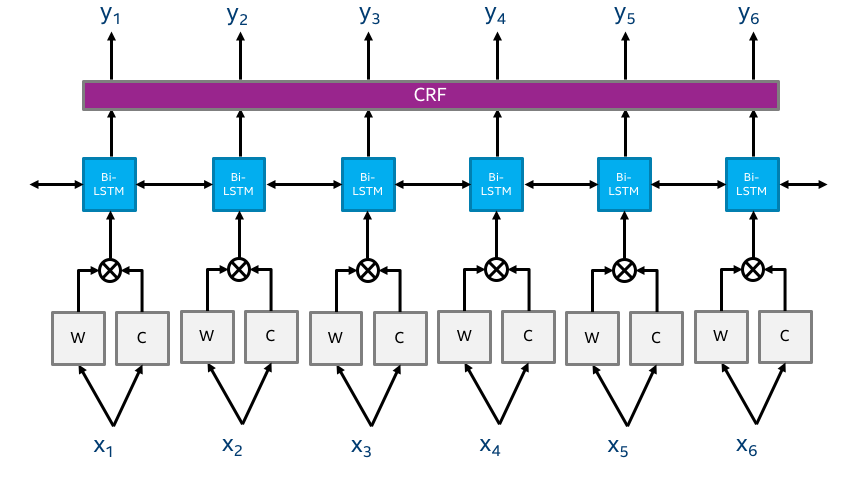

We have 2 input source (words and word characters), a bi-directional LSTM layer and a CRF layer for token classification.

There's a class in NLP Architect that implements the above model, called `NERCRF` from `nlp_architect.models.ner_crf`.


In [ ]:
ner_model = NERCRF()
ner_model.build(sentence_length,
                word_length,
                num_y_labels,
                dataset.word_vocab,
                dataset.word_vocab_size ,
                dataset.char_vocab_size,
                word_embedding_dims=embedding_size,
                external_embedding_model=embedding_path)

## Training
set batch size and number of epochs and fit the data on the network.

In [ ]:
batch_size = 32
num_epochs = 1

ner_model.fit(x=[x_train, x_char_train], y=y_train,
                  batch_size=batch_size,
                  epochs=num_epochs,
                  validation=([x_test, x_char_test], y_test))

## Evaluation
Once the model has trained. Run CONLLEVAL to see how well it performs.

In [ ]:
predictions = ner_model.predict(x=[x_test, x_char_test], batch_size=1)
eval = get_conll_scores(predictions, y_test, {v: k for k, v in dataset.y_labels.items()})

In [ ]:
print('Precision {}'.format(eval[0][0]))
print('Recall {}'.format(eval[0][1]))
print('F1 {}'.format(eval[0][2]))